In [206]:
import re
import pandas as pd
import pandas 
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import copy

In [221]:
def ConvertSeasonToTime(data:str):
    year, season = data.split("Q")    
    time = "{y}-{m}-{d}".format(y=year, m=3*int(season), d=30)
    time = pd.to_datetime(time, format="%Y-%m-%d")
    return time

def FilterColumn(df:pandas.DataFrame):
    cols = copy.deepcopy(df.columns.values)
    for i, col in enumerate(cols):
        if col in cols[:i]:
            cols[i] = col + "%"
    df.columns = cols
    return df

In [210]:
def GetCashFlows(stockID:int, mode):
    headers = {
      'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36'  
    }
    
    #res = requests.get("https://goodinfo.tw/StockInfo/StockBzPerformance.asp?STOCK_ID={ID}&YEAR_PERIOD=9999&RPT_CAT=M_QUAR".format(ID = stockID), headers = headers)

    res = requests.get('https://goodinfo.tw/StockInfo/StockCashFlow.asp?STOCK_ID={ID}&RPT_CAT=M_QUAR'.format(ID = stockID), headers = headers)
    res.encoding = 'utf-8'
    
    soup = BeautifulSoup(res.text, 'lxml')
    data = soup.select_one('#txtFinDetailData')
    dfs = pd.read_html(data.prettify())
    df = dfs[0]

    #取最後一欄欄位
    df.columns = df.columns.get_level_values(-1)
    
    # "-" 去除掉, 換成 NaN
    df = df.applymap(lambda x: np.nan if x == "-" else x)
    
    # "2020Q4" 換成 datatime
    df.index = df["季度"].map(lambda x: ConvertSeasonToTime(x))
    df.index.name = "時間"
    df = df.drop(columns = "季度")
    
    # 轉換成 float
    df.applymap(lambda x: float(x))

 
    return df
    #res.text
df = GetCashFlows(2330)
df[:10]

TypeError: GetCashFlows() missing 1 required positional argument: 'mode'

In [211]:
stockID = 2330

headers = {
  'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36'  
}
#res = requests.get('https://goodinfo.tw/StockInfo/StockCashFlow.asp?STOCK_ID={ID}&RPT_CAT=M_QUAR'.format(ID = stockID), headers = headers)
res = requests.get("https://goodinfo.tw/StockInfo/StockBzPerformance.asp?STOCK_ID={ID}&YEAR_PERIOD=9999&RPT_CAT=M_QUAR".format(ID = stockID), headers = headers)
res.encoding = 'utf-8'

In [212]:
soup = BeautifulSoup(res.text, 'lxml')
data = soup.select_one('#txtFinDetailData')
dfs = pd.read_html(data.prettify())

In [229]:
df = dfs[-1]

#取最後一欄欄位
df.columns = df.columns.get_level_values(-1)

#只取文字出來, 去除空白
df.columns = ["".join(re.findall("\w+", i)) for i in df.columns]
df = FilterColumn(df)

# "-" 去除掉, 換成 NaN
df = df.applymap(lambda x: np.nan if x == "-" else x)

# "2020Q4" 換成 datatime
df.index = df["季度"].map(lambda x: ConvertSeasonToTime(x))
df.index.name = "時間"
df = df.drop(columns = "季度")

# 轉換成 float
df = df.applymap(lambda x: float(x))
display(df.columns)
df[:5]

Index(['股本億', '財報評分', '收盤', '平均', '漲跌', '漲跌%', '營業收入', '營業毛利', '營業利益', '業外損益',
       '稅後淨利', '營業毛利%', '營業利益%', '業外損益%', '稅後淨利%', '單季ROE', '年估ROE', '單季ROA',
       '年估ROA', '稅後EPS', '年增元', 'BPS元'],
      dtype='object')

,股本億,財報評分,收盤,平均,漲跌,漲跌%,營業收入,營業毛利,營業利益,業外損益,...,營業利益%,業外損益%,稅後淨利%,單季ROE,年估ROE,單季ROA,年估ROA,稅後EPS,年增元,BPS元
時間,,,,,,,,,,,,,,,,,,,,,
2020-12-30,NaN,NaN,449.0,450.0,16.0,3.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-30,NaN,NaN,433.0,411.0,120.0,38.3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-30,2593.0,96.0,313.0,299.0,39.0,14.2,3107.0,1646.0,1311.0,53.0,...,42.2,1.71,38.9,7.12,28.5,5.05,20.2,4.66,2.09,66.35
2020-03-30,2593.0,96.0,274.0,313.0,-57.0,-17.2,3106.0,1608.0,1285.0,36.3,...,41.4,1.17,37.7,7.10,28.4,5.08,20.3,4.51,2.14,64.64
2019-12-30,2593.0,96.0,331.0,308.0,59.0,21.7,3172.0,1592.0,1242.0,45.4,...,39.2,1.43,36.6,7.23,28.9,5.28,21.1,4.48,0.62,62.53


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 38291 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 38291 missing from current font.
  font.set_text(s, 0, flags=flags)


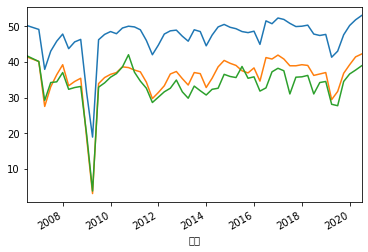

In [238]:
df["營業毛利%"].dropna().plot()

df["營業利益%"].dropna().plot()
df["稅後淨利%"].dropna().plot()


In [209]:
df.columns.values

array(['股本億%', 'A', '收盤%', '平均%', '漲跌', '漲跌%', '營業收入', '營業毛利', '營業利益',
       '業外損益', '稅後淨利', '營業毛利%', '營業利益%', '業外損益%', '稅後淨利%', '單季ROE',
       '年估ROE', '單季ROA', '年估ROA', '稅後EPS', '年增元', 'BPS元'], dtype=object)